## Load data files

In [5]:
import codecs
from keras.utils.np_utils import to_categorical
import numpy as np

def load_data(filename):
    data = list(codecs.open(filename, 'r', 'utf-8').readlines())
    x, y = zip(*[d.strip().split('\t') for d in data])
    x = np.asarray(list(x))
    y = to_categorical(y, 3)
    
    return x, y
    
x_token_train, y_token_train = load_data('data/token_train.tsv')
x_token_test, y_token_test = load_data('data/token_test.tsv')
x_morph_train, y_morph_train = load_data('data/morph_train.tsv')
x_morph_test, y_morph_test = load_data('data/morph_test.tsv')

print('X token train shape: {}'.format(x_token_train.shape))
print('X token test shape: {}'.format(x_token_test.shape))

print('X morph train shape: {}'.format(x_morph_train.shape))
print('X morph test shape: {}'.format(x_morph_test.shape))

X token train shape: (10244,)
X token test shape: (2560,)
X morph train shape: (10244,)
X morph test shape: (2560,)


## Prepare
Convert text (train & test) to sequences and pad to requested document length

In [6]:
from keras.preprocessing import text, sequence

def tokenizer(x_train, x_test, vocabulary_size, char_level):
    tokenize = text.Tokenizer(num_words=vocabulary_size, 
                              char_level=char_level,
                              filters='')
    tokenize.fit_on_texts(x_train)  # only fit on train
    x_train = tokenize.texts_to_sequences(x_train)
    x_test = tokenize.texts_to_sequences(x_test)
    
    return x_train, x_test

def pad(x_train, x_test, max_document_length):
    x_train = sequence.pad_sequences(x_train, maxlen=max_document_length, padding='post', truncating='post')
    x_test = sequence.pad_sequences(x_test, maxlen=max_document_length, padding='post', truncating='post')
    
    return x_train, x_test

vocabulary_size = 5000

x_token_train, x_token_test = tokenizer(x_token_train, x_token_test, vocabulary_size, True)
x_morph_train, x_morph_test = tokenizer(x_morph_train, x_morph_test, vocabulary_size, True)

max_document_length = 300

x_token_train, x_token_test = pad(x_token_train, x_token_test, max_document_length)
x_morph_train, x_morph_test = pad(x_morph_train, x_morph_test, max_document_length)

print('X token train shape: {}'.format(x_token_train.shape))
print('X token test shape: {}'.format(x_token_test.shape))

print('X morph train shape: {}'.format(x_morph_train.shape))
print('X morph test shape: {}'.format(x_morph_test.shape))

X token train shape: (10244, 300)
X token test shape: (2560, 300)
X morph train shape: (10244, 300)
X morph test shape: (2560, 300)


In [4]:
print('Token OOV ratio: {} ({} out of 228)'.format(np.count_nonzero(x_token_test == 228)/228, np.count_nonzero(x_token_test == 228)))
print('Morph OOV ratio: {} ({} out of 228)'.format(np.count_nonzero(x_morph_test == 228)/228, np.count_nonzero(x_morph_test == 228)))

Token OOV ratio: 0.03508771929824561 (8 out of 228)
Morph OOV ratio: 0.03508771929824561 (8 out of 228)


## Plot function

In [7]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    
    fig, axs = plt.subplots(1, 2, sharex=True)
    
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].legend(['Train', 'Validation'], loc='upper left')
    
    axs[1].plot(history.history['acc'])
    axs[1].plot(history.history['val_acc'])
    axs[1].set_title('Model Accuracy')
    axs[1].legend(['Train', 'Validation'], loc='upper left')
    
    fig.tight_layout()
    plt.show()

## Import required modules from Keras

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPool1D
from keras.layers import BatchNormalization
from keras import optimizers
from keras import metrics
from keras import backend as K

## Default Parameters

In [9]:
dropout_keep_prob = 0.5
embedding_size = 300
batch_size = 50
lr = 1e-4
dev_size = 0.2

## Linear - Token

Train on 8195 samples, validate on 2049 samples
Epoch 1/10
8195/8195 [==============================] - 1s 133us/step - loss: 4.6573 - acc: 0.5634 - val_loss: 3.4261 - val_acc: 0.6837
Epoch 2/10
8195/8195 [==============================] - 1s 90us/step - loss: 3.9497 - acc: 0.6367 - val_loss: 3.3253 - val_acc: 0.6886
Epoch 3/10
8195/8195 [==============================] - 1s 96us/step - loss: 3.7765 - acc: 0.6476 - val_loss: 3.1227 - val_acc: 0.6950
Epoch 4/10
8195/8195 [==============================] - 1s 81us/step - loss: 3.7338 - acc: 0.6401 - val_loss: 3.2283 - val_acc: 0.7013
Epoch 5/10
8195/8195 [==============================] - 1s 87us/step - loss: 3.4944 - acc: 0.6491 - val_loss: 2.9340 - val_acc: 0.7003
Epoch 6/10
8195/8195 [==============================] - 1s 86us/step - loss: 3.4322 - acc: 0.6454 - val_loss: 2.6599 - val_acc: 0.7013
Epoch 7/10
8195/8195 [==============================] - 1s 86us/step - loss: 3.2137 - acc: 0.6420 - val_loss: 2.4780 - val_acc: 0.6920
Epoch 

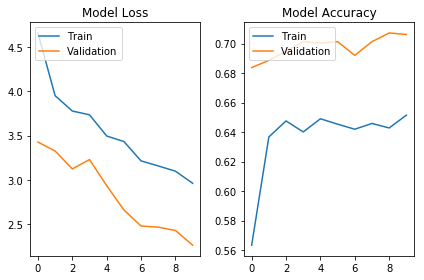

2560/2560 [==============================] - 0s 28us/step

Accurancy: 0.6938


In [11]:
num_epochs = 10

# Create new TF graph
K.clear_session()

# Construct model
text_input = Input(shape=(max_document_length,))
x = Dense(100)(text_input)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_token_train, y_token_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_token_test, y_token_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.4f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/Linear-Token-{:.3f}.h5'.format((scores[1] * 100)))

## Linear - Morph

Train on 8195 samples, validate on 2049 samples
Epoch 1/10
8195/8195 [==============================] - 1s 118us/step - loss: 4.3945 - acc: 0.5639 - val_loss: 3.2610 - val_acc: 0.6925
Epoch 2/10
8195/8195 [==============================] - 0s 60us/step - loss: 3.8549 - acc: 0.6339 - val_loss: 3.2650 - val_acc: 0.6974
Epoch 3/10
8195/8195 [==============================] - 1s 69us/step - loss: 3.7139 - acc: 0.6430 - val_loss: 3.0271 - val_acc: 0.6959
Epoch 4/10
8195/8195 [==============================] - 0s 57us/step - loss: 3.5929 - acc: 0.6361 - val_loss: 2.9381 - val_acc: 0.6989
Epoch 5/10
8195/8195 [==============================] - 1s 66us/step - loss: 3.4279 - acc: 0.6482 - val_loss: 2.8578 - val_acc: 0.6950
Epoch 6/10
8195/8195 [==============================] - 0s 56us/step - loss: 3.3378 - acc: 0.6392 - val_loss: 2.7722 - val_acc: 0.6959
Epoch 7/10
8195/8195 [==============================] - 0s 54us/step - loss: 3.2074 - acc: 0.6430 - val_loss: 2.5296 - val_acc: 0.6901
Epoch 

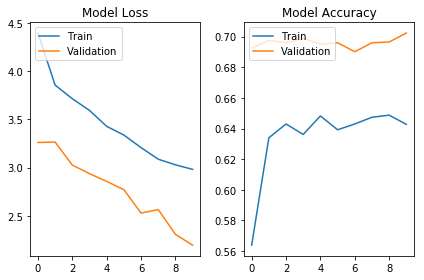

2560/2560 [==============================] - 0s 20us/step

Accurancy: 0.6871


In [12]:
# Create new TF graph
K.clear_session()

# Construct model
text_input = Input(shape=(max_document_length,))
x = Dense(100)(text_input)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_morph_train, y_morph_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_morph_test, y_morph_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.4f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/Linear-Morph-{:.3f}.h5'.format((scores[1] * 100)))

## CNN - Token

Train on 8195 samples, validate on 2049 samples
Epoch 1/5
8195/8195 [==============================] - 963s 118ms/step - loss: 0.6787 - acc: 0.7087 - val_loss: 0.6599 - val_acc: 0.7091
Epoch 2/5
8195/8195 [==============================] - 899s 110ms/step - loss: 0.6171 - acc: 0.7451 - val_loss: 0.5897 - val_acc: 0.7438
Epoch 3/5
8195/8195 [==============================] - 1610s 196ms/step - loss: 0.5314 - acc: 0.7863 - val_loss: 0.5533 - val_acc: 0.7589
Epoch 4/5
8195/8195 [==============================] - 1429s 174ms/step - loss: 0.4513 - acc: 0.8253 - val_loss: 0.5300 - val_acc: 0.7823
Epoch 5/5
8195/8195 [==============================] - 968s 118ms/step - loss: 0.3758 - acc: 0.8630 - val_loss: 0.4583 - val_acc: 0.8199


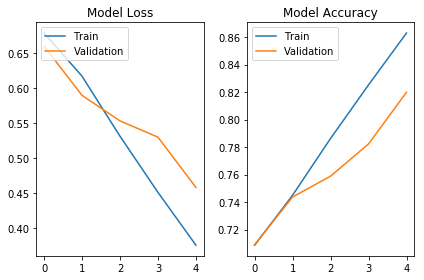

2560/2560 [==============================] - 80s 31ms/step

Accurancy: 0.824


In [13]:
num_epochs = 5

# Create new TF graph
K.clear_session()

# Construct model
convs = []
text_input = Input(shape=(max_document_length,))
x = Embedding(vocabulary_size, embedding_size)(text_input)
for fsz in [10, 30]:
    conv = Conv1D(128, fsz, padding='valid', activation='relu')(x)
    pool = MaxPool1D()(conv)
    convs.append(pool)
x = Concatenate(axis=1)(convs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_token_train, y_token_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_token_test, y_token_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.3f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/CNN-Token-{:.3f}.h5'.format((scores[1] * 100)))


## CNN - Morph

Train on 8195 samples, validate on 2049 samples
Epoch 1/5
8195/8195 [==============================] - 879s 107ms/step - loss: 0.6855 - acc: 0.7013 - val_loss: 0.6589 - val_acc: 0.7096
Epoch 2/5
8195/8195 [==============================] - 812s 99ms/step - loss: 0.6271 - acc: 0.7353 - val_loss: 0.5972 - val_acc: 0.7496
Epoch 3/5
8195/8195 [==============================] - 807s 98ms/step - loss: 0.5391 - acc: 0.7780 - val_loss: 0.5406 - val_acc: 0.7716
Epoch 4/5
8195/8195 [==============================] - 802s 98ms/step - loss: 0.4715 - acc: 0.8148 - val_loss: 0.4960 - val_acc: 0.7916
Epoch 5/5
8195/8195 [==============================] - 802s 98ms/step - loss: 0.4075 - acc: 0.8461 - val_loss: 0.5182 - val_acc: 0.7897


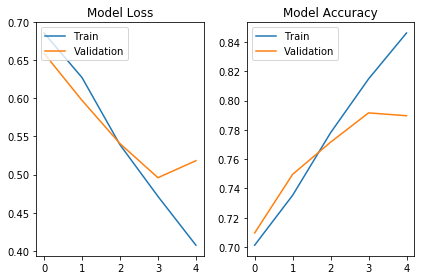

2560/2560 [==============================] - 78s 30ms/step

Accurancy: 0.7855


In [14]:
# Create new TF graph
K.clear_session()

# Construct model
convs = []
text_input = Input(shape=(max_document_length,))
x = Embedding(vocabulary_size, embedding_size)(text_input)
for fsz in [10, 30]:
    conv = Conv1D(128, fsz, padding='valid', activation='relu')(x)
    pool = MaxPool1D()(conv)
    convs.append(pool)
x = Concatenate(axis=1)(convs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_morph_train, y_morph_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_morph_test, y_morph_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.4f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/CNN-Morph-{:.3f}.h5'.format((scores[1] * 100)))

## LSTM - Token

Train on 8195 samples, validate on 2049 samples
Epoch 1/7
8195/8195 [==============================] - 272s 33ms/step - loss: 0.8362 - acc: 0.6589 - val_loss: 0.7334 - val_acc: 0.6603
Epoch 2/7
8195/8195 [==============================] - 268s 33ms/step - loss: 0.7338 - acc: 0.6835 - val_loss: 0.7153 - val_acc: 0.7003
Epoch 3/7
8195/8195 [==============================] - 255s 31ms/step - loss: 0.7200 - acc: 0.6979 - val_loss: 0.7114 - val_acc: 0.6994
Epoch 4/7
8195/8195 [==============================] - 252s 31ms/step - loss: 0.7188 - acc: 0.6995 - val_loss: 0.7151 - val_acc: 0.6994
Epoch 5/7
8195/8195 [==============================] - 254s 31ms/step - loss: 0.7155 - acc: 0.7007 - val_loss: 0.7100 - val_acc: 0.6999
Epoch 6/7
8195/8195 [==============================] - 251s 31ms/step - loss: 0.7119 - acc: 0.7015 - val_loss: 0.7092 - val_acc: 0.6999
Epoch 7/7
8195/8195 [==============================] - 252s 31ms/step - loss: 0.7103 - acc: 0.7014 - val_loss: 0.7094 - val_acc: 0.7008


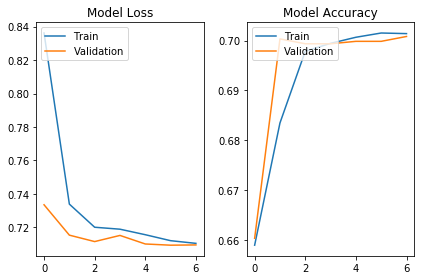

2560/2560 [==============================] - 20s 8ms/step

Accurancy: 0.695


In [15]:
num_epochs = 7
lstm_units = 93

# Create new TF graph
K.clear_session()

# Construct model
text_input = Input(shape=(max_document_length,))
x = Embedding(vocabulary_size, embedding_size)(text_input)
x = LSTM(units=lstm_units, return_sequences=True)(x)
x = LSTM(units=lstm_units)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_token_train, y_token_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_token_test, y_token_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.3f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/LSTM-Token-{:.3f}.h5'.format((scores[1] * 100)))


## LSTM - Morph

Train on 8195 samples, validate on 2049 samples
Epoch 1/7
8195/8195 [==============================] - 253s 31ms/step - loss: 0.8080 - acc: 0.6534 - val_loss: 0.7334 - val_acc: 0.6593
Epoch 2/7
8195/8195 [==============================] - 252s 31ms/step - loss: 0.7272 - acc: 0.6704 - val_loss: 0.7250 - val_acc: 0.6593
Epoch 3/7
8195/8195 [==============================] - 252s 31ms/step - loss: 0.7142 - acc: 0.7014 - val_loss: 0.7073 - val_acc: 0.7091
Epoch 4/7
8195/8195 [==============================] - 253s 31ms/step - loss: 0.7039 - acc: 0.7049 - val_loss: 0.7041 - val_acc: 0.7028
Epoch 5/7
8195/8195 [==============================] - 251s 31ms/step - loss: 0.7050 - acc: 0.7053 - val_loss: 0.7071 - val_acc: 0.7038
Epoch 6/7
8195/8195 [==============================] - 251s 31ms/step - loss: 0.7037 - acc: 0.7070 - val_loss: 0.7047 - val_acc: 0.7042
Epoch 7/7
8195/8195 [==============================] - 253s 31ms/step - loss: 0.6972 - acc: 0.7093 - val_loss: 0.6922 - val_acc: 0.7135


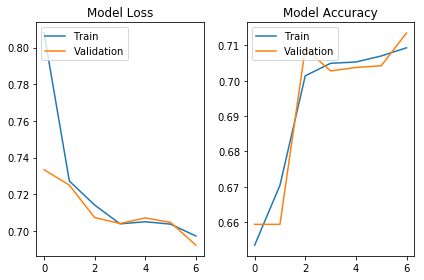

2560/2560 [==============================] - 20s 8ms/step

Accurancy: 0.706


In [16]:
# Create new TF graph
K.clear_session()

# Construct model
text_input = Input(shape=(max_document_length,))
x = Embedding(vocabulary_size, embedding_size)(text_input)
x = LSTM(units=lstm_units, return_sequences=True)(x)
x = LSTM(units=lstm_units)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_morph_train, y_morph_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_morph_test, y_morph_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.3f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/LSTM-Morph-{:.3f}.h5'.format((scores[1] * 100)))

## BiLSTM - Token

Train on 8195 samples, validate on 2049 samples
Epoch 1/4
8195/8195 [==============================] - 646s 79ms/step - loss: 0.7930 - acc: 0.6696 - val_loss: 0.6746 - val_acc: 0.6999
Epoch 2/4
8195/8195 [==============================] - 647s 79ms/step - loss: 0.6525 - acc: 0.7174 - val_loss: 0.6345 - val_acc: 0.7125
Epoch 3/4
8195/8195 [==============================] - 647s 79ms/step - loss: 0.6233 - acc: 0.7236 - val_loss: 0.6086 - val_acc: 0.7291
Epoch 4/4
8195/8195 [==============================] - 657s 80ms/step - loss: 0.6046 - acc: 0.7407 - val_loss: 0.6129 - val_acc: 0.7365


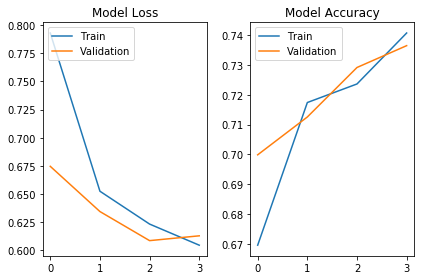

2560/2560 [==============================] - 47s 18ms/step

Accurancy: 0.737


In [17]:
num_epochs = 4

# Create new TF graph
K.clear_session()

# Construct model
text_input = Input(shape=(max_document_length,))
x = Embedding(vocabulary_size, embedding_size)(text_input)
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(x)
x = Bidirectional(LSTM(units=lstm_units))(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_token_train, y_token_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_token_test, y_token_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.3f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/BiLSTM-Token-{:.3f}.h5'.format((scores[1] * 100)))

## BiLSTM - Morph

Train on 8195 samples, validate on 2049 samples
Epoch 1/4
8195/8195 [==============================] - 666s 81ms/step - loss: 0.7960 - acc: 0.6636 - val_loss: 0.6901 - val_acc: 0.6789
Epoch 2/4
8195/8195 [==============================] - 662s 81ms/step - loss: 0.6700 - acc: 0.6990 - val_loss: 0.6409 - val_acc: 0.7160
Epoch 3/4
8195/8195 [==============================] - 661s 81ms/step - loss: 0.6261 - acc: 0.7254 - val_loss: 0.6234 - val_acc: 0.7189
Epoch 4/4
8195/8195 [==============================] - 660s 80ms/step - loss: 0.6072 - acc: 0.7304 - val_loss: 0.6061 - val_acc: 0.7384


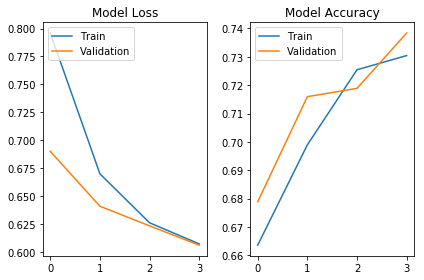

2560/2560 [==============================] - 46s 18ms/step

Accurancy: 0.731


In [18]:
# Create new TF graph
K.clear_session()

# Construct model
text_input = Input(shape=(max_document_length,))
x = Embedding(vocabulary_size, embedding_size)(text_input)
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(x)
x = Bidirectional(LSTM(units=lstm_units))(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_morph_train, y_morph_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_morph_test, y_morph_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.3f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/BiLSTM-Morph-{:.3f}.h5'.format((scores[1] * 100)))

## MLP - Token

Train on 8195 samples, validate on 2049 samples
Epoch 1/6
8195/8195 [==============================] - 148s 18ms/step - loss: 0.8018 - acc: 0.6542 - val_loss: 0.6827 - val_acc: 0.7101
Epoch 2/6
8195/8195 [==============================] - 146s 18ms/step - loss: 0.7361 - acc: 0.6790 - val_loss: 0.6675 - val_acc: 0.7130
Epoch 3/6
8195/8195 [==============================] - 146s 18ms/step - loss: 0.7016 - acc: 0.6985 - val_loss: 0.6436 - val_acc: 0.7130
Epoch 4/6
8195/8195 [==============================] - 146s 18ms/step - loss: 0.6782 - acc: 0.7085 - val_loss: 0.6273 - val_acc: 0.7272
Epoch 5/6
8195/8195 [==============================] - 146s 18ms/step - loss: 0.6321 - acc: 0.7348 - val_loss: 0.5946 - val_acc: 0.7413
Epoch 6/6
8195/8195 [==============================] - 146s 18ms/step - loss: 0.5681 - acc: 0.7640 - val_loss: 0.5611 - val_acc: 0.7516


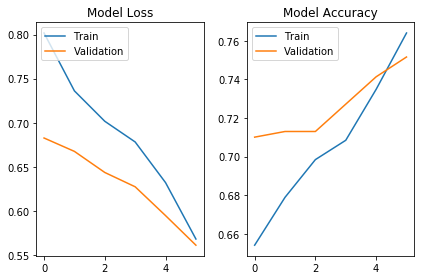

2560/2560 [==============================] - 5s 2ms/step

Accurancy: 0.746


In [19]:
num_epochs = 6

# Create new TF graph
K.clear_session()

# Construct model
text_input = Input(shape=(max_document_length,))
x = Embedding(vocabulary_size, embedding_size)(text_input)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_token_train, y_token_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_token_test, y_token_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.3f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/MLP-Token-{:.3f}.h5'.format((scores[1] * 100)))

## MLP - Morph

Train on 8195 samples, validate on 2049 samples
Epoch 1/6
8195/8195 [==============================] - 148s 18ms/step - loss: 0.8144 - acc: 0.6342 - val_loss: 0.6832 - val_acc: 0.7052
Epoch 2/6
8195/8195 [==============================] - 146s 18ms/step - loss: 0.7343 - acc: 0.6786 - val_loss: 0.6664 - val_acc: 0.7111
Epoch 3/6
8195/8195 [==============================] - 146s 18ms/step - loss: 0.6986 - acc: 0.6965 - val_loss: 0.6470 - val_acc: 0.7179
Epoch 4/6
8195/8195 [==============================] - 145s 18ms/step - loss: 0.6575 - acc: 0.7170 - val_loss: 0.6295 - val_acc: 0.7194
Epoch 5/6
8195/8195 [==============================] - 146s 18ms/step - loss: 0.6160 - acc: 0.7378 - val_loss: 0.6030 - val_acc: 0.7335
Epoch 6/6
8195/8195 [==============================] - 146s 18ms/step - loss: 0.5639 - acc: 0.7667 - val_loss: 0.5822 - val_acc: 0.7452


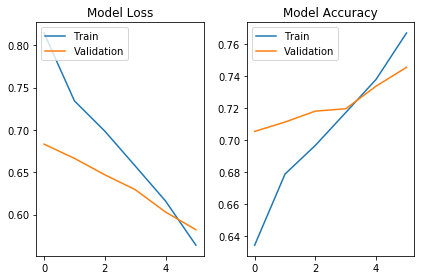

2560/2560 [==============================] - 5s 2ms/step

Accurancy: 0.745


In [20]:
# Create new TF graph
K.clear_session()

# Construct model
text_input = Input(shape=(max_document_length,))
x = Embedding(vocabulary_size, embedding_size)(text_input)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(text_input, preds)

adam = optimizers.Adam(lr=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_morph_train, y_morph_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=dev_size)

# Plot training accuracy and loss
plot_loss_and_accuracy(history)

# Evaluate the model
scores = model.evaluate(x_morph_test, y_morph_test,
                       batch_size=batch_size, verbose=1)
print('\nAccurancy: {:.3f}'.format(scores[1]))

# Save the model
model.save('char_saved_models/MLP-Morph-{:.3f}.h5'.format((scores[1] * 100)))